In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Entrez
from Bio import Medline


In [2]:
df = pd.read_csv("../disprot/DisProt_release_2023_123_with_ambiguous_evidences.tsv", sep='\t')
uniprot_id_df = pd.read_csv("../uniprot_disorder_genes/idmapping_2024_09_19.tsv", sep='\t')
clinvar_missense_nopfam_df = pd.read_csv("../ClinVar/clinvar.snp.header.chr.nopfam.noalt.missense.cava.tsv", sep='\t')
ensemble_to_refseq_mapping_df = pd.read_csv("../gene2refseq/gene2ensembl.tsv", sep='\t')
wgs_bed_df = pd.read_csv("../gene2refseq/MANE_WGS.tsv", sep='\t')
af2_disorder_df = pd.read_csv("../alphafold/AlphaFold_disorder.human.tsv", sep='\t', header=None)
af2_disorder_df.columns = ['PID', 'START', "STOP", "GENE", 'ENSEMBLE_ID']
af2_disorder_df = af2_disorder_df[~af2_disorder_df['ENSEMBLE_ID'].isna()]                           
#mobidb_df = pd.read_csv('../mobidb/mobidb_result_2024-09-24T14_53_01.780Z.tsv', sep='\t')

/tmp/ipykernel_2185133/2709860477.py:3: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_missense_nopfam_df = pd.read_csv("../ClinVar/clinvar.snp.header.chr.nopfam.noalt.missense.cava.tsv", sep='\t')


In [3]:
#af2_disorder_df['IN_DISPROT'] 
df_renamed = df.rename(columns={'acc': 'PID', 'start': 'START', 'end': 'STOP'})
merged = af2_disorder_df.merge(df_renamed, on=['PID', 'START', 'STOP'], how='left', indicator=True)
af2_disorder_df['IN_DISPROT'] = (merged['_merge'] == 'both').astype(int)

In [4]:
af2_disorder_df[af2_disorder_df['IN_DISPROT'] == 1]
af2_disorder_df.to_csv('../output/regions_in_disport.csv', index=False)

In [5]:
df_human = df[df['ncbi_taxon_id'] == 9606]

In [6]:
AF2_disorder_uniprod_df = pd.merge(af2_disorder_df, uniprot_id_df, left_on='PID' ,right_on='From', how='left')

In [7]:
def generate_gene_bed(df):
    filtered_df = df[~df['Gene Names (primary)'].str.contains(';', na=False)]
    new_df = filtered_df[[ 'START', 'STOP', 'Gene Names (primary)', 'RNA_nucleotide_accession.version', 'From']]
    new_df.columns = ['GSTART', "GEND", 'GENES', "TRANSCRIPT", "UNIPROT_ID"]
    new_df['TRANSCRIPT_NOV'] = new_df['TRANSCRIPT'].str.split('.').str[0]
    new_df = new_df.drop_duplicates()
    new_df = new_df.reset_index(drop=True)
    return new_df




In [8]:
#disorder_uniprod_df['ensemble_MANE'] = disorder_uniprod_df['MANE-Select'].str.split(";").str[0]
#disorder_uniprod_df['ensemble_MANE'] = disorder_uniprod_df['ensemble_MANE'].str.split(" ").str[0]


In [9]:
# Filter the DataFrame for rows where the value in 'RNA_nucleotide_accession.version' starts with 'NM_'
ensemble_to_refseq_df = ensemble_to_refseq_mapping_df[ensemble_to_refseq_mapping_df['RNA_nucleotide_accession.version'].str.startswith('NM_') &
                                                     ensemble_to_refseq_mapping_df['Ensembl_rna_identifier'].str.startswith('ENST')]
ensemble_to_refseq_df = ensemble_to_refseq_df[ensemble_to_refseq_df['#tax_id'] == 9606]
ensemble_to_refseq_df = ensemble_to_refseq_df[['RNA_nucleotide_accession.version', 'Ensembl_rna_identifier']]
ensemble_to_refseq_df = ensemble_to_refseq_df.drop_duplicates()
ensemble_to_refseq_df = ensemble_to_refseq_df.reset_index(drop=True)

In [10]:
disorder_uniprod_ref_df = pd.merge(AF2_disorder_uniprod_df, ensemble_to_refseq_df, left_on='ENSEMBLE_ID', 
                                   right_on='Ensembl_rna_identifier', how='left')

In [11]:
disorder_bed_df = generate_gene_bed(disorder_uniprod_ref_df)
disorder_bed_df
wgs_bed_df['TRANSCRIPT_NOV'] = wgs_bed_df['TRANSCRIPT'].str.split('.').str[0]


/tmp/ipykernel_2185133/929154101.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['TRANSCRIPT_NOV'] = new_df['TRANSCRIPT'].str.split('.').str[0]


In [12]:
disorder_bed_wgs_df = pd.merge(disorder_bed_df, wgs_bed_df, right_on='TRANSCRIPT_NOV', 
                               left_on='TRANSCRIPT_NOV', how='left')

disorder_genes= list(set(disorder_bed_wgs_df.GENES.tolist()))
disorder_disprot_df = disorder_bed_wgs_df[['CHROM', 'GSTART', 'GEND', 'GENES', 'TRANSCRIPT_x', 'TRANSCRIPT_NOV', 'UNIPROT_ID']]
                                           

In [13]:
disorder_disprot_df.to_csv("../AF2_disorder_regions.bed", sep='\t', index=False, header=None)


In [14]:
#clinvar_missense_nopfam_df = clinvar_missense_nopfam_df.replace('.', np.nan, inplace=True)
clinvar_data_df = clinvar_missense_nopfam_df[['#CHROM', "POS", "REF", "ALT", 
                                         'CAVA_CLASS', 'CAVA_CSN', 
                                         'CAVA_GENE', 'CAVA_GENEID', 'CAVA_IMPACT', 'CAVA_LOC', 'CAVA_PROTALT',
                                         'CAVA_PROTPOS', 'CAVA_PROTREF', 'CAVA_SO', 'CAVA_TRANSCRIPT', 
                                         'CLNSIG', 'CLNHGVS', 'CLNVC', 'CLNREVSTAT']]
clinvar_data_disorder_df =  clinvar_data_df[clinvar_data_df['CAVA_GENE'].isin(disorder_genes)]
clinvar_data_disorder_df = clinvar_data_disorder_df[clinvar_data_disorder_df['CAVA_SO'] == 'missense_variant']
clinvar_data_disorder_df.CLNSIG.value_counts()

keep_class = ['Likely_pathogenic', 'Pathogenic/Likely_pathogenic', 'Pathogenic|drug_response',
                    'Pathogenic', 'Pathogenic|other', 'Pathogenic/Likely_pathogenic|other', 'Likely_pathogenic|other',
                    'Likely_pathogenic/Likely_risk_allele', 'Likely_benign', 'Benign', 'Benign/Likely_benign', 'Uncertain_significance']
clinvar_data_disorder_keep_df = clinvar_data_disorder_df[clinvar_data_disorder_df['CLNSIG'].isin(keep_class)]



In [15]:
clinvar_data_disorder_merged_df = pd.merge(clinvar_data_disorder_keep_df, disorder_disprot_df, left_on='CAVA_GENE', right_on='GENES')
clinvar_data_disorder_merged_df['CAVA_PROTPOS'] = clinvar_data_disorder_merged_df['CAVA_PROTPOS'].astype(int)
clinvar_data_disorder_merged_df = clinvar_data_disorder_merged_df[clinvar_data_disorder_merged_df['CAVA_GENE'] != "PTEN"]
clinvar_data_disorder_merged_filtered_df = clinvar_data_disorder_merged_df[(clinvar_data_disorder_merged_df['CAVA_PROTPOS'] >= clinvar_data_disorder_merged_df['GSTART']) & (clinvar_data_disorder_merged_df['CAVA_PROTPOS'] <= clinvar_data_disorder_merged_df['GEND'])]
clnsig_counts = clinvar_data_disorder_merged_filtered_df.CLNSIG.value_counts()

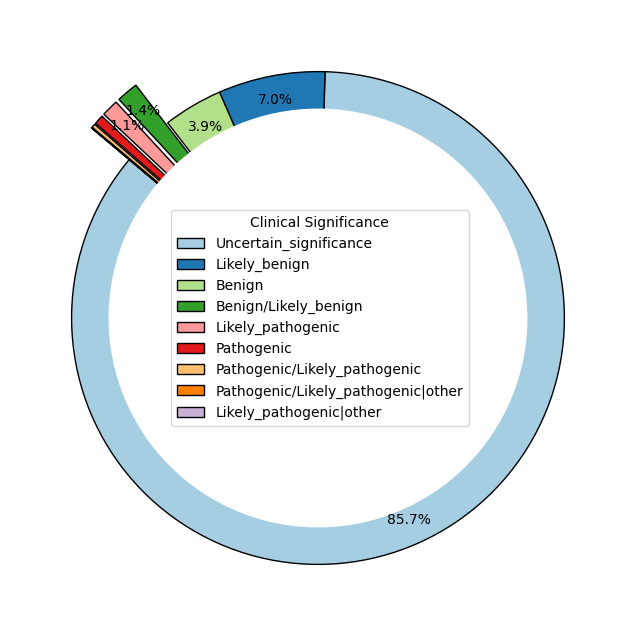

In [16]:
# Set up the figure size
plt.figure(figsize=(8, 8))

# Create a donut chart with optimized label placement
wedges, texts, autotexts = plt.pie(
    clnsig_counts.values, 
    labels=None,  # Hide labels in the pie to prevent overlap
    autopct=lambda p: f'{p:.1f}%' if p > 1 else '',  # Hide very small percentages
    startangle=140,  # Rotate for better visualization
    colors=plt.cm.Paired.colors,  # Use a diverse colormap
    wedgeprops={'edgecolor': 'black'},  # Add border to slices
    pctdistance=0.90,  # Push percentage labels closer to slices
    explode=[0.2 if val < 500 else 0 for val in clnsig_counts.values]  # Separate small slices
)

# Draw a white circle in the middle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.85, fc='white')
plt.gca().add_artist(centre_circle)

# Add category labels outside the pie chart
plt.legend(wedges, clnsig_counts.index, title="Clinical Significance", loc="center left", bbox_to_anchor=(0.25, 0.5))
plt.savefig("clinvar_idr_distribution.png", dpi=300)
# Set title
#plt.title("Distribution of Clinical Significance Labels", fontsize=14)

# Show the plot
plt.show()

In [17]:
pathogenic_class = ['Likely_pathogenic', 'Pathogenic', 'Pathogenic/Likely_pathogenic', 
                    'Pathogenic/Likely_pathogenic|other', 'Likely_pathogenic|other']
clinvar_data_disorder_pathogenic_df = clinvar_data_disorder_merged_filtered_df[clinvar_data_disorder_merged_filtered_df['CLNSIG'].isin(pathogenic_class)] 
clinvar_data_disorder_pathogenic_df = clinvar_data_disorder_pathogenic_df.drop(['CHROM', 'GSTART', 'GEND', 'TRANSCRIPT_x'], axis=1)
clinvar_data_disorder_pathogenic_df = clinvar_data_disorder_pathogenic_df[clinvar_data_disorder_pathogenic_df['CAVA_GENE'] != "PTEN"]
clinvar_data_disorder_pathogenic_df = clinvar_data_disorder_pathogenic_df.drop_duplicates()
clinvar_data_disorder_pathogenic_df = clinvar_data_disorder_pathogenic_df.reset_index(drop=True)
disorder_pathogenic_genes = list(set(clinvar_data_disorder_pathogenic_df.CAVA_GENE.tolist()))
clinvar_data_disorder_pathogenic_df['Class'] = 'Deleterious'
clinvar_data_disorder_pathogenic_df['Class'].value_counts()

Deleterious    322
Name: Class, dtype: int64

In [18]:
benign_class = ['Likely_benign', 'Benign', 'Benign/Likely_benign']
clinvar_data_disorder_benign_df = clinvar_data_disorder_merged_filtered_df[clinvar_data_disorder_merged_filtered_df['CLNSIG'].isin(benign_class)] 
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df.drop(['CHROM', 'GSTART', 'GEND', 'TRANSCRIPT_x'], axis=1)
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df[clinvar_data_disorder_benign_df['CAVA_GENE'] != "PTEN"]
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df.drop_duplicates()
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df.reset_index(drop=True)
#clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df[clinvar_data_disorder_benign_df['CAVA_GENE'].isin(disorder_pathogenic_genes)]
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df.drop_duplicates()
clinvar_data_disorder_benign_df = clinvar_data_disorder_benign_df.reset_index(drop=True)
clinvar_data_disorder_benign_df['Class'] = 'Neutral'
clinvar_data_disorder_benign_df.Class.value_counts()

Neutral    1973
Name: Class, dtype: int64

In [19]:
vus_class = ['Uncertain_significance']
clinvar_data_disorder_vus_df = clinvar_data_disorder_merged_filtered_df[clinvar_data_disorder_merged_filtered_df['CLNSIG'].isin(vus_class)] 
clinvar_data_disorder_vus_df = clinvar_data_disorder_vus_df.drop(['CHROM', 'GSTART', 'GEND', 'TRANSCRIPT_x'], axis=1)
clinvar_data_disorder_vus_df = clinvar_data_disorder_vus_df[clinvar_data_disorder_vus_df['CAVA_GENE'] != "PTEN"]
clinvar_data_disorder_vus_df = clinvar_data_disorder_vus_df.drop_duplicates()
clinvar_data_disorder_vus_df = clinvar_data_disorder_vus_df.reset_index(drop=True)
disorder_vus_genes = list(set(clinvar_data_disorder_vus_df.CAVA_GENE.tolist()))
clinvar_data_disorder_vus_df['Class'] = 'VUS'
clinvar_data_disorder_vus_df['Class'].value_counts()

VUS    13704
Name: Class, dtype: int64

In [20]:
clinvar_data_disorder_results_df = pd.concat([clinvar_data_disorder_pathogenic_df, clinvar_data_disorder_benign_df, clinvar_data_disorder_vus_df], axis=0)

/tmp/ipykernel_2185133/4205326587.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clnsig_updated_counts.index, y=clnsig_updated_counts.values, palette="viridis")


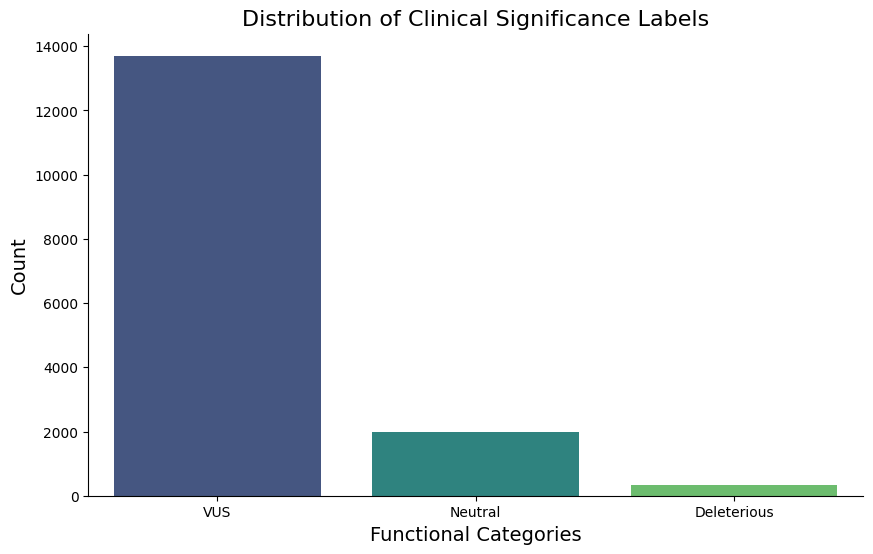

In [21]:
clnsig_updated_counts = clinvar_data_disorder_results_df.Class.value_counts()

# Set up the figure size
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x=clnsig_updated_counts.index, y=clnsig_updated_counts.values, palette="viridis")

# Labels and title
plt.xlabel("Functional Categories", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Clinical Significance Labels", fontsize=16)
sns.despine()
# Rotate x-axis labels for better readability
#plt.xticks(rotation=45, ha='right')
plt.savefig("disorder_idr_mutation_counts.png", dpi=300)
# Show the plot
plt.show()

In [22]:
clinvar_AF2_disorder_results_df = clinvar_data_disorder_results_df[[ 'CAVA_CSN','CAVA_PROTALT',
       'CAVA_PROTPOS', 'CAVA_PROTREF', 'CAVA_TRANSCRIPT', 'CLNSIG', 'CLNREVSTAT',
       'CLNHGVS', 'GENES',
       'UNIPROT_ID', 'Class']]
clinvar_AF2_disorder_results_df['mutation'] = (
    clinvar_AF2_disorder_results_df['CAVA_PROTREF'].astype(str) +
    clinvar_AF2_disorder_results_df['CAVA_PROTPOS'].astype(str) +
    clinvar_AF2_disorder_results_df['CAVA_PROTALT'].astype(str)
)

/tmp/ipykernel_2185133/3810214413.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_AF2_disorder_results_df['mutation'] = (


In [23]:
clinvar_AF2_disorder_results_merge_df = pd.merge(clinvar_AF2_disorder_results_df, disorder_disprot_df, on="GENES", how="inner")

clinvar_AF2_disorder_results_merge_df["within_interval"] = (clinvar_AF2_disorder_results_merge_df["CAVA_PROTPOS"] >= clinvar_AF2_disorder_results_merge_df["GSTART"]) & (clinvar_AF2_disorder_results_merge_df["CAVA_PROTPOS"] <= clinvar_AF2_disorder_results_merge_df["GEND"])
clinvar_AF2_disorder_results_merge_df = clinvar_AF2_disorder_results_merge_df[clinvar_AF2_disorder_results_merge_df["within_interval"]]

In [24]:
clinvar_AF2_disorder_results_merge_df.to_csv('../alphafold/AF2_Disorder_deleterious_neutral_vus_results.tsv', sep='\t', index=False)


In [25]:
study_gene_list = list(set(clinvar_data_disorder_results_df.CAVA_GENE.tolist()))
study_gene_list = study_gene_list + ['BRCA2', "PALB2", "RAD51C", "PALB2", "TP53"]

In [26]:
with open ("../aim2_gene_list.csv", 'w+') as fout:
    for i in study_gene_list:
        fout.write(i + '\n')

In [27]:
study_regions_df = wgs_bed_df[wgs_bed_df['GENE'].isin(study_gene_list)]
study_regions_df = study_regions_df.drop_duplicates()
study_regions_df = study_regions_df.reset_index(drop=True)
study_regions_df.to_csv("../aim2_regions_genes.tsv", sep='\t', index=False)